## Introduction
The following notebook provides an estimate of Value At Risk (VaR) and Median Shortfall (Median Shortfall) using Extreme Value Theory on daily simple returns of the NASDAQ Composite indices from 22/04/2019 to 21/05/2021.

<br>
Authors:
<br>
Krzysztof Ignasiak
<br>
Patryk Szymkowiak

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from data_cleaner import *
from model import *

## Data preparation

In [2]:
Nasdaq = pd.read_csv('data/NASDAQ Composite Historical Data.csv',parse_dates=['Date'])


In [3]:
Nasdaq.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [4]:
Nasdaq.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 21, 2021","13,470.99","13,616.19","13,616.58","13,463.26",786.55M,-0.48%
1,"May 20, 2021","13,535.74","13,356.63","13,563.52","13,355.71",810.41M,1.77%
2,"May 19, 2021","13,299.74","13,078.19","13,304.61","13,072.23",879.28M,-0.03%
3,"May 18, 2021","13,303.64","13,416.90","13,485.34","13,299.92",852.73M,-0.56%
4,"May 17, 2021","13,379.05","13,368.80","13,399.17","13,265.40",799.86M,-0.38%


In [5]:
Nasdaq = parse_date(Nasdaq,'Date')

In [6]:

Nasdaq = format_volume(Nasdaq,'Vol.')

In [7]:
Nasdaq = percentage_text_to_float(Nasdaq,'Change %')

In [8]:
Nasdaq = Nasdaq.rename(columns={'Vol._new': 'Volume'})
Nasdaq = clean_numeric_data(Nasdaq,['Price','Open','High','Low','Volume'])

In [9]:
Nasdaq.set_index('Date', inplace=True)
Nasdaq.sort_index(inplace=True)


## Visualization

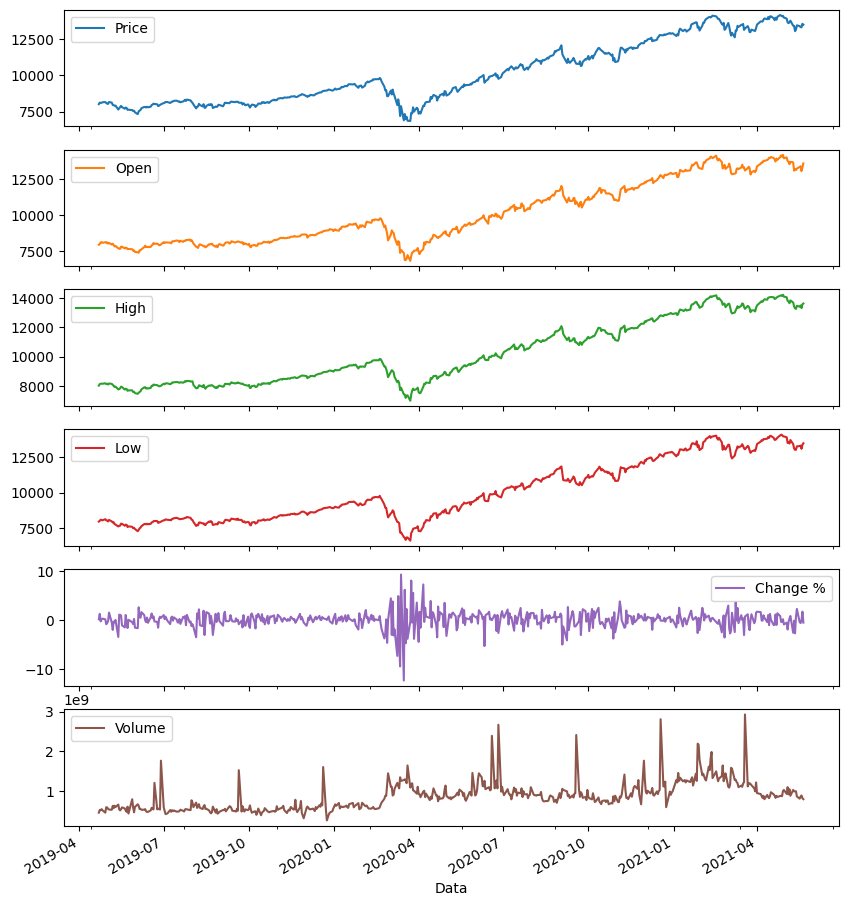

In [10]:
Nasdaq.sort_values(by='Date', inplace=True)
Nasdaq.plot(subplots=True, figsize=(10,12))
plt.gcf().autofmt_xdate()
plt.xlabel('Data')
plt.show()

## Forecasting

In [11]:
value_at_risk_prediction = in_sample_prediction(Nasdaq['Change %'],100,10,0.05)
median_shortfall_prediction = in_sample_prediction(Nasdaq['Change %'],100,10,0.025)

In [12]:
# Combine prediction and the real values
forecast_df = pd.concat([Nasdaq['Change %'],value_at_risk_prediction,median_shortfall_prediction],axis=1)

In [13]:
forecast_df.columns = ['Change %','PredictionVaR','PredictionMS']

## Results visualisation

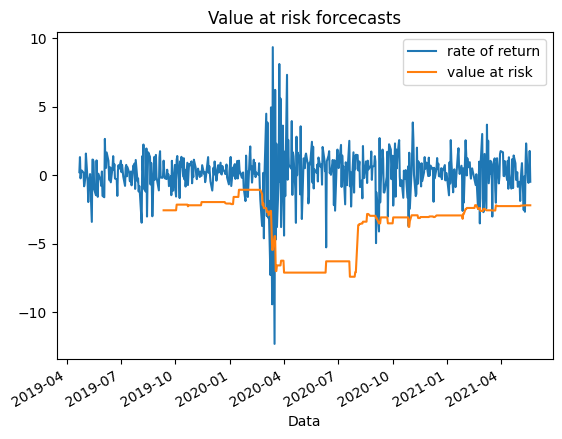

In [14]:
forecast_df.rename(columns={"Change %":"rate of return","PredictionVaR":"value at risk"}).plot(y = ['rate of return','value at risk'])
plt.title('Value at risk forcecasts')
plt.gcf().autofmt_xdate()
plt.xlabel('Data')
plt.show()

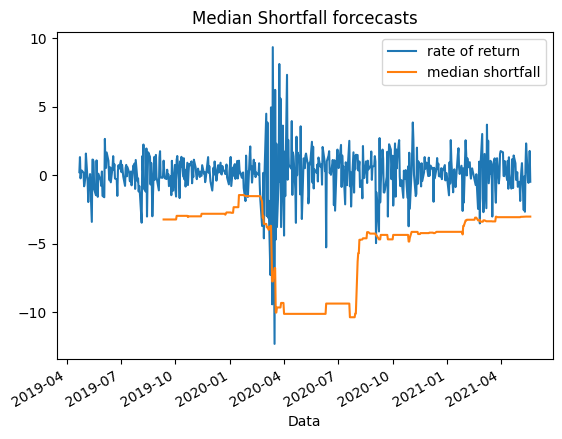

In [15]:
forecast_df.rename(columns={"Change %":"rate of return","PredictionMS":"median shortfall"}).plot(y = ['rate of return','median shortfall'])
plt.title('Median Shortfall forcecasts')
plt.gcf().autofmt_xdate()
plt.xlabel('Data')
plt.show()

## Statistical verification

Tests defined in r will be used to statistically verify the estimates.

In [16]:
%load_ext rpy2.ipython

In [17]:
%%R
# Check if the rugarch package is installed
if (!requireNamespace("rugarch", quietly = TRUE)) {
  install.packages("rugarch")
}

# Check if the xts package is installed
if (!requireNamespace("xts", quietly = TRUE)) {
  install.packages("xts")
}

# Load the rugarch and xts packages
library(rugarch)
library(xts)

Loading required package: parallel

Attaching package: ‘rugarch’

The following object is masked from ‘package:stats’:

    sigma

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [ ]:
%%R
InSamplePredictionsVaR <- forecast_df['PredictionVaR'][100:527]
InSamplePredictionsMS <-  forecast_df['PredictionMS']100:527]
InSampleChanges <- as.vector(forecast_df['Change %'][100:527])

In [ ]:
%%R
BackTestVaR = VaRTest(alpha = 0.05, InSampleChanges, InSamplePredictionsVaR, conf.level = 0.95)
BackTestMS = VaRTest(alpha = 0.025, InSampleChanges, InSamplePredictionsMS, conf.level = 0.95)

In [ ]:
%%R
BackTestVaR

In [ ]:
%%R
BackTestMS